In [2]:
import torch
import tqdm
from visualization import plot_all_poses
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

In [3]:

# Set up config for optimization
args = {
    'gpu_id':       '0',
    'data_dir':     './data',
    'result_dir':   './exp',
    'save_dir':     'model',
    'train':        True,
    'lr':           0.001,
    'epoch':        50000
}
os.makedirs(args['save_dir'], exist_ok=True)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:%s" % args['gpu_id'] if use_cuda else "cpu")
dtype = torch.float32

In [4]:
def load_features(path):
    with np.load(path) as data:
        features = data['data']
        frames = data['image_names']
        intri = data['intrinsic']
    return torch.from_numpy(features).to(dtype), frames, torch.from_numpy(intri).to(dtype)

In [5]:
# Load features and intrinsics
features, frames, K = load_features(os.path.join(args['data_dir'],'sift_features.npz'))

In [6]:
def visualize_reprojection(images:list, calib_feature:torch.Tensor, reproj: torch.Tensor, K:torch.Tensor):
    """
    images: [np.array]                  Images
    features_2d: torch.tensor[N,F,2]    Given calibrated features
    reproj: torch.tensor[N,F,2]         Reprojected 3d features normalized by z
    K: torch.tensor[3,3]                     Intrinsics in 
    """
    def p2(calibrated_points):
        """
        Calibrated points to pixels
        """
        key3d = torch.cat([calibrated_points,torch.ones((calibrated_points.shape[0], calibrated_points.shape[1],1)).to(dtype)],dim=-1) @ K.T
        key2d = key3d[:,:,:2]/key3d[:,:,2].unsqueeze(-1)
        key2d[:,:,0] = key2d[:,:,0].clamp(0, 4032)
        key2d[:,:,1] = key2d[:,:,1].clamp(0, 3024)
        return key2d
    
    if calib_feature is not None:
        calib_2d = p2(calib_feature)

    if reproj is not None:
        reproj_2d = p2(reproj)

    fig, ax = plt.subplots(1, len(images),figsize=(20,5))
    for f in range(len(images)):
        ax[f].imshow(images[f])
        if calib_feature is not None:
            ax[f].plot(calib_2d[:,f,0],calib_2d[:,f,1],'ro', markersize = 2)
        if reproj is not None:
            ax[f].plot(reproj_2d[:,f,0],reproj_2d[:,f,1],'bo', markersize = 2)
    plt.show()


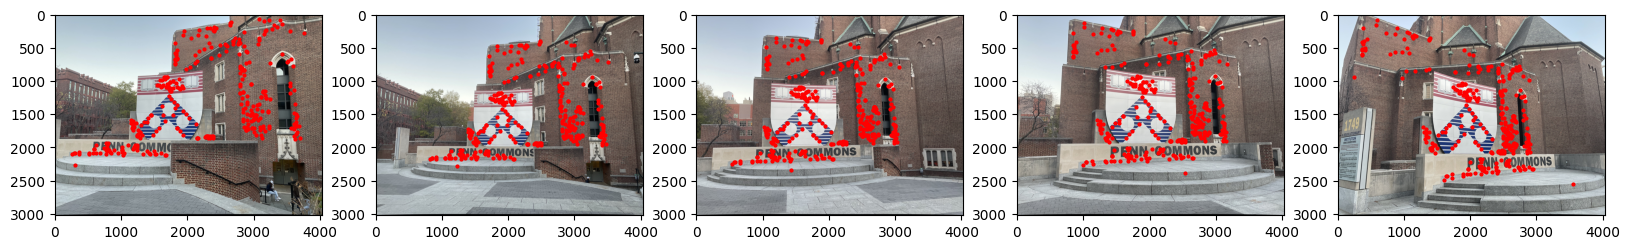

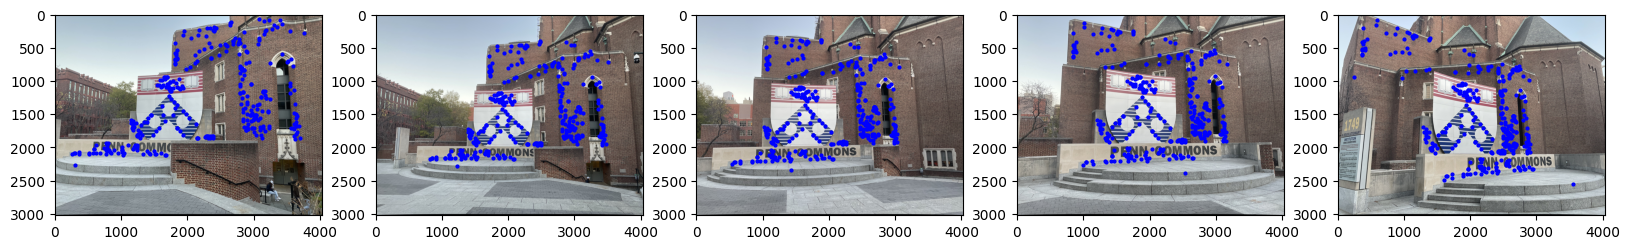

In [7]:
# Load features and frames
images = []
for f in range(frames.shape[0]):
    image = cv2.imread(os.path.join('./data/pennlogo',frames[f]))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)
    
# Test with given calibrated features
visualize_reprojection(images, features, None, K)
visualize_reprojection(images, None, features, K)

In [9]:
# Prepare data for BA
batch = {
        'features': features.to(torch.float32),
        'N': features.shape[0],
        'F': len(frames)
    }

  0%|          | 0/50000 [00:00<?, ?it/s, loss=0.0896]

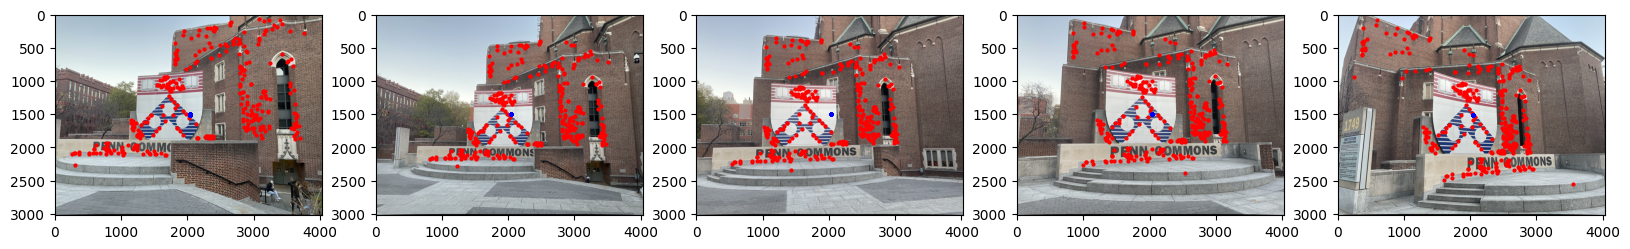

  4%|▍         | 1985/50000 [00:17<04:48, 166.63it/s, loss=0.000775]

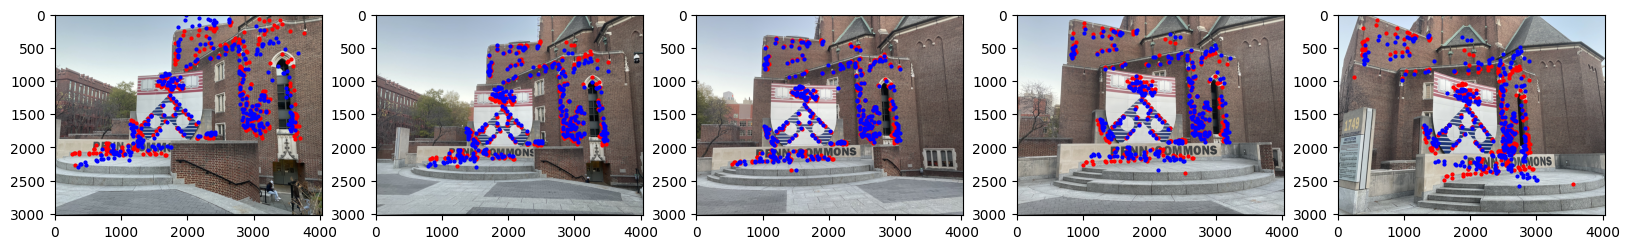

  8%|▊         | 3996/50000 [00:33<04:18, 177.89it/s, loss=0.000641] 

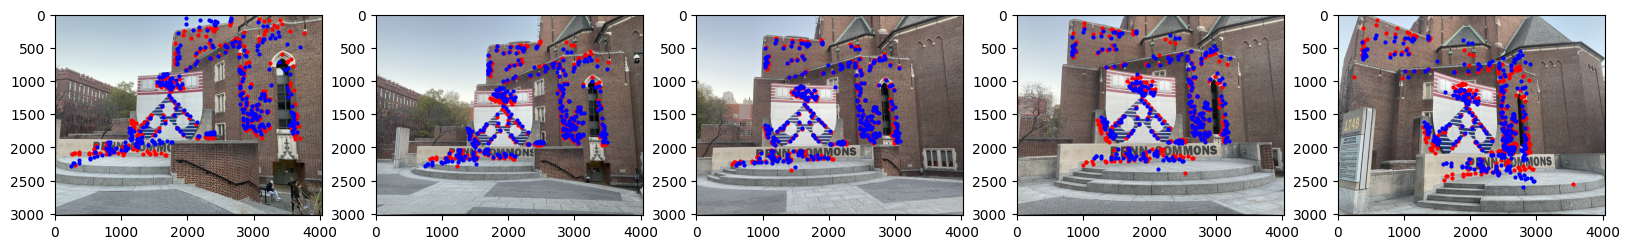

 12%|█▏        | 5988/50000 [00:50<04:05, 179.17it/s, loss=0.000618] 

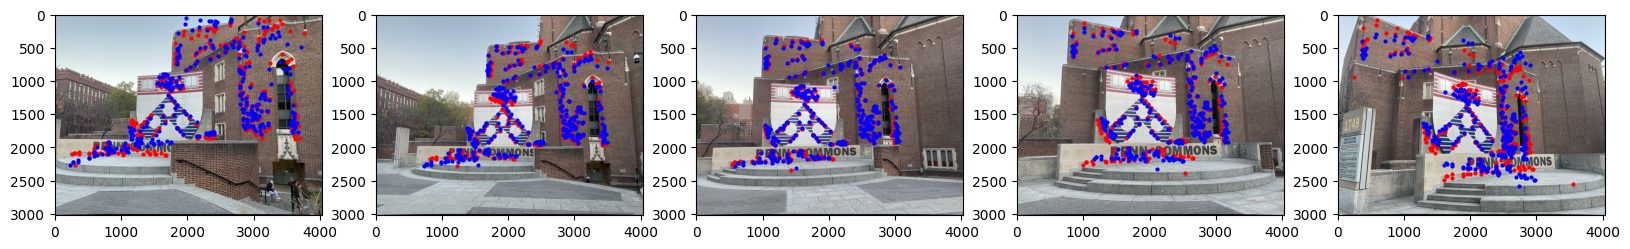

 16%|█▌        | 7999/50000 [01:06<03:57, 177.03it/s, loss=0.000611] 

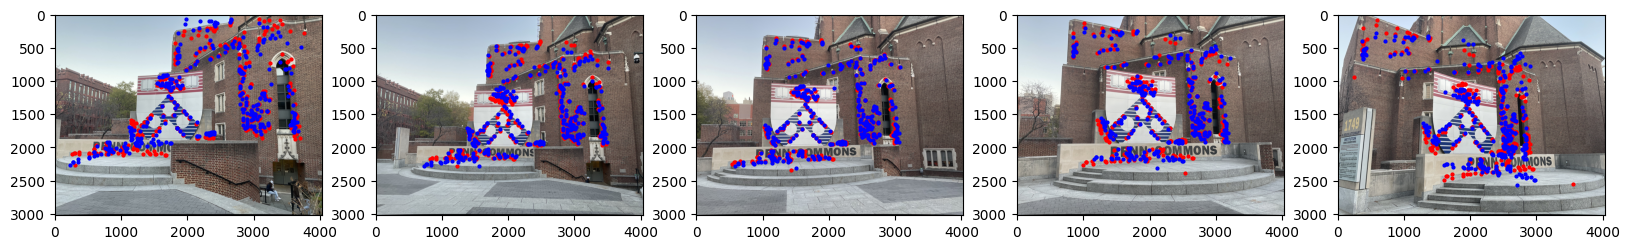

 20%|█▉        | 9989/50000 [01:22<03:44, 178.49it/s, loss=0.000606]

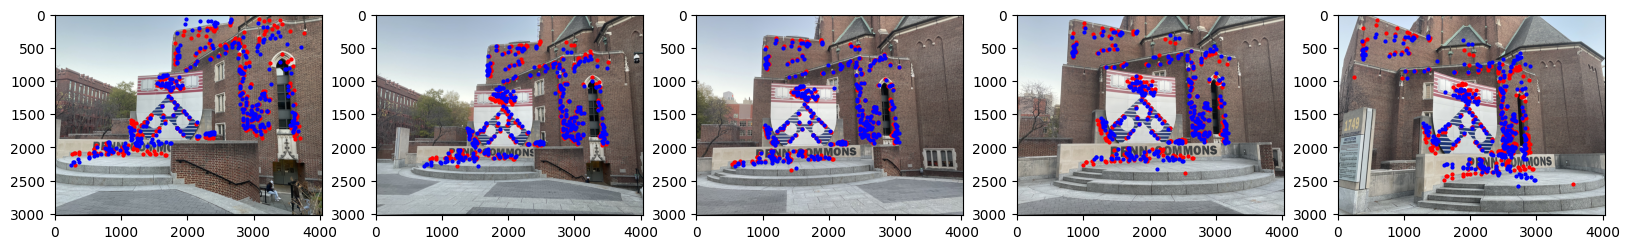

 24%|██▍       | 11985/50000 [01:39<03:36, 175.31it/s, loss=0.000605]

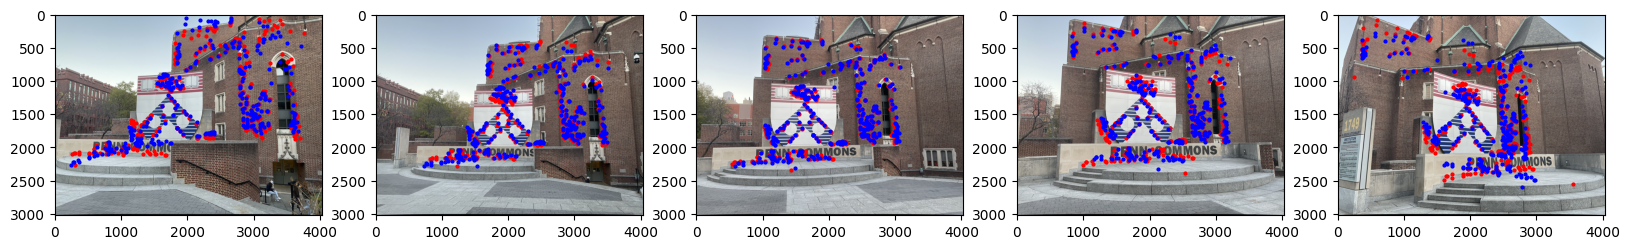

 28%|██▊       | 13989/50000 [01:55<03:23, 176.59it/s, loss=0.000601]

In [ ]:
# Once you finished torch_BA.py you can run this training scrip to optimize parameters.
from torch_BA import torch_BA
min_loss = torch.inf
epoch = args['epoch']

BA_backend = torch_BA(batch['F'], batch['N'], batch['features'], device, args['lr'])

if args['train']:
    pbar = tqdm.tqdm(range(epoch))
    for iter in pbar:
        loss = BA_backend.forward_one_step()
        pbar.set_postfix({
            'loss': float(loss)
        })
        if iter % 2000 == 0:
            key3d_norm = BA_backend.reprojection(False)
            viz = visualize_reprojection(images, features, key3d_norm, K)

            if loss< min_loss:
                torch.save({
                    'model_state_dict': BA_backend.state_dict(),
                }, '%s/model.pkl' % args['save_dir'])
else:
    checkpoint = torch.load('%s/model.pkl' % args['save_dir'], map_location=device)
    BA_backend.load_state_dict(checkpoint['model_state_dict'])
        


In [ ]:
# After optimization you can copy all the code to a .py file and plot the figure with interactive window.
# Set args['Train']=False

theta, trans, key3d = BA_backend.save_parameters(to_rotm=True)
theta = torch.inverse(theta)
trans = (theta @ -trans.unsqueeze(-1) ).squeeze(-1)
poses = torch.cat([theta, trans.unsqueeze(-1)], dim=-1) 
plot_all_poses(poses.numpy(), key3d.numpy())

In [1]:
# for colmap parameters, save the parameters for gradescope evaluation
# SUBMIT THIS TO GRADESCOPE
theta, trans, key3d = BA_backend.save_parameters(to_rotm=False)
np.savez("colmap_parameters.npz", theta = theta.numpy(), trans = trans.numpy(), key3d = key3d.numpy())


NameError: name 'BA_backend' is not defined